# Digit Recognition with Advanced CNN Architecture:

In [ ]:
!pip install torch torchvision torchaudio



Epoch [1/10], Loss: 0.2731710352789936
Epoch [2/10], Loss: 0.11924557218244716
Epoch [3/10], Loss: 0.09530899105921213
Epoch [4/10], Loss: 0.08378523908421966
Epoch [5/10], Loss: 0.07203309717766845
Epoch [6/10], Loss: 0.04934480372192795
Epoch [7/10], Loss: 0.04464489685000181
Epoch [8/10], Loss: 0.04220760052280028
Epoch [9/10], Loss: 0.03816385463016408
Epoch [10/10], Loss: 0.037276554758772694


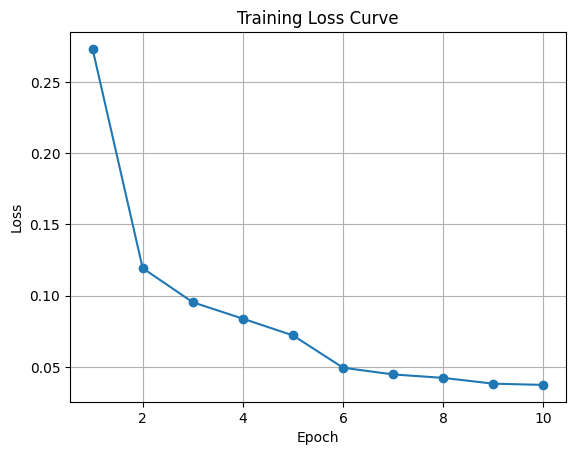

Test Accuracy: 98.84%
F1 Score: 0.9884


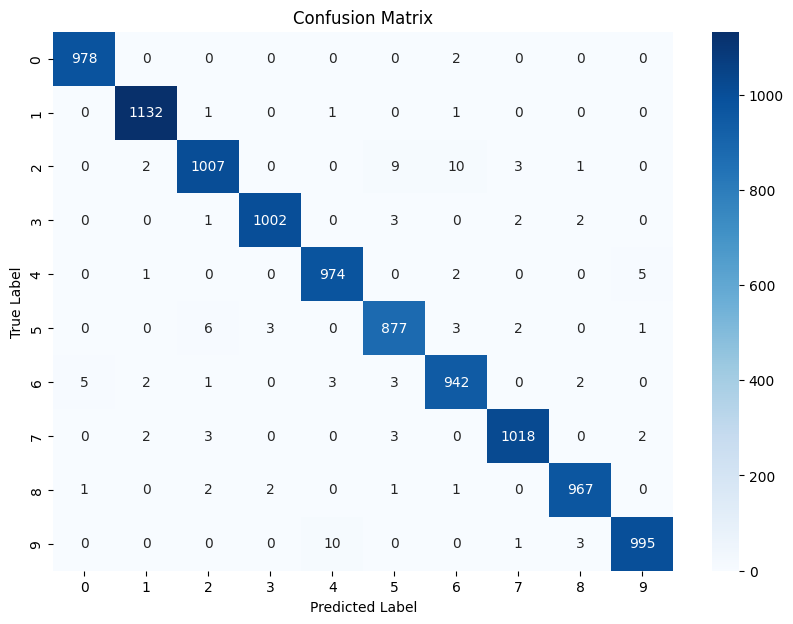

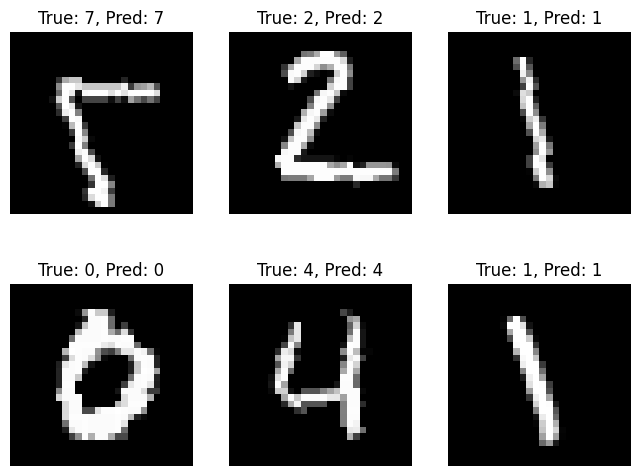

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation (Normalization + Data Augmentation)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),      # Randomly rotate images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training and test dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define an advanced CNN Model
class AdvancedDocumentRecognitionCNN(nn.Module):
    def __init__(self):
        super(AdvancedDocumentRecognitionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, 10)  # Output for 10 classes (0-9 digits)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv -> BatchNorm -> ReLU -> Pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)  # Flatten the feature maps for fully connected layers
        x = F.relu(self.fc1(x))  # First fully connected layer with ReLU
        x = self.dropout(x)  # Dropout layer to avoid overfitting
        x = self.fc2(x)  # Output layer
        return x

# Initialize the model
model = AdvancedDocumentRecognitionCNN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler

# Training Loop with scheduler
num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero out gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))
    scheduler.step()  # Update learning rate
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader)}")

# Plot the training loss over epochs
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Testing the model
model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []
with torch.no_grad():  #Lets disable gradient tracking for testing
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy, F1 score
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix Visualization
def plot_confusion_matrix(model, testloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Call the function to visualize confusion matrix
plot_confusion_matrix(model, testloader)

# Function to display test images and predictions
def visualize_predictions(model, testloader):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(testloader))  # Take a batch of test data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  # Get predicted labels

    # Visualize the first 6 test images and their predictions
    fig, axes = plt.subplots(2, 3, figsize=(8, 6))
    for i in range(6):
        ax = axes[i // 3, i % 3]
        ax.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        ax.set_title(f"True: {labels[i].item()}, Pred: {predicted[i].item()}")
        ax.axis('off')
    plt.show()

# Call the function to visualize predictions
visualize_predictions(model, testloader)
